In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
# Step 1: Install Kaggle inside Colab
!pip install -q kaggle

# Step 2: Upload your Kaggle API key
import os
from google.colab import files
if not os.path.exists("/root/.kaggle/kaggle.json"):
    files.upload()  # Upload kaggle.json

# Step 3: Setup Kaggle credentials
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 4: Download the dataset from Kaggle
!kaggle datasets download -d borhanitrash/animal-image-classification-dataset -p /content

# Step 5: Unzip the dataset
!unzip -q /content/animal-image-classification-dataset.zip -d /content/animal_photos

# ✅ FIX: Import pathlib
import pathlib

# Step 6: Point data_dir to the extracted folder
data_dir = pathlib.Path("/content/animal_photos")
print("Dataset Path:", data_dir)
print("Subfolders:", [f.name for f in data_dir.iterdir()])



Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/borhanitrash/animal-image-classification-dataset
License(s): MIT
  0% 0.00/38.4M [00:00<?, ?B/s]
100% 38.4M/38.4M [00:00<00:00, 1.14GB/s]
Dataset Path: /content/animal_photos
Subfolders: ['Animals', 'README.md']


/content/animal_photos/Animals/cats/0_0165.jpg


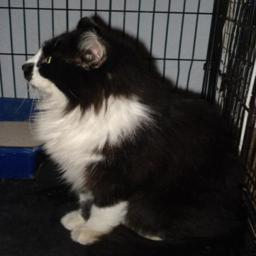

In [ ]:
import PIL.Image

# Correct path for cats folder inside Animals
cats = list(data_dir.glob('Animals/cats/*'))

print(cats[0])  # print first image path
PIL.Image.open(str(cats[0]))  # open the first cat image


In [ ]:
import tensorflow as tf
import pathlib

img_height, img_width = 180, 180
batch_size = 32

# Load full dataset without split
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir / "Animals",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=1  # batch=1 so we can count exact images
)

# Save class names
class_names = full_ds.class_names
print("Classes:", class_names)

# Count total images
num_images = len(list(full_ds.unbatch()))
print("Total images:", num_images)

# Calculate split sizes
train_size = int(0.7 * num_images)
val_size = int(0.15 * num_images)
test_size = num_images - train_size - val_size
print(f"Train: {train_size}, Val: {val_size}, Test: {test_size}")

# Reload dataset for splitting (with desired batch size)
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir / "Animals",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Shuffle and split
full_ds = full_ds.shuffle(buffer_size=num_images, seed=123)

train_ds = full_ds.take(train_size // batch_size)
rest = full_ds.skip(train_size // batch_size)
val_ds = rest.take(val_size // batch_size)
test_ds = rest.skip(val_size // batch_size)

print("Splits created successfully!")


Found 3000 files belonging to 3 classes.
Classes: ['cats', 'dogs', 'snakes']
Total images: 3000
Train: 2100, Val: 450, Test: 450
Found 3000 files belonging to 3 classes.
Splits created successfully!


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir / "Animals",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 3000 files belonging to 3 classes.
Using 600 files for validation.


In [ ]:
print("Class names:", class_names)


Class names: ['cats', 'dogs', 'snakes']


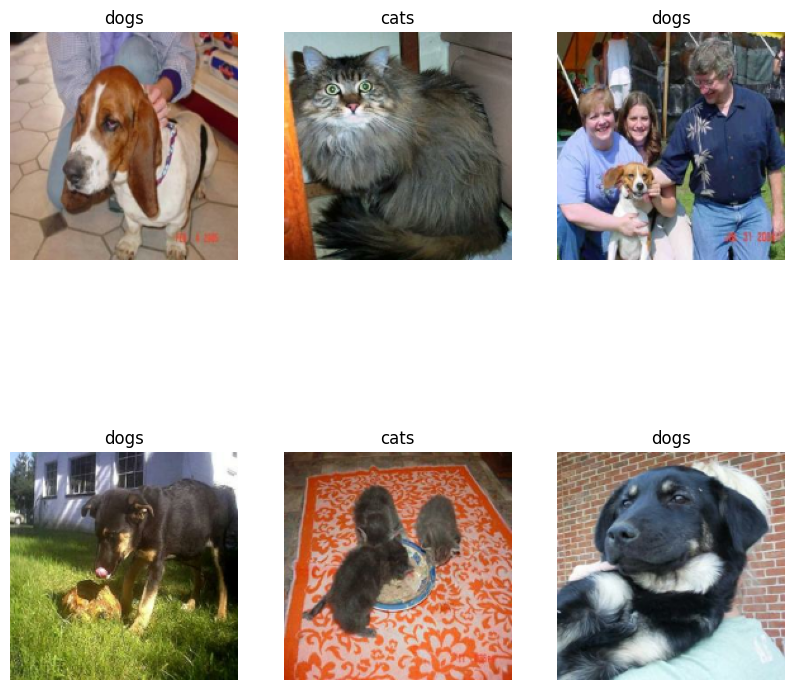

In [ ]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):  # show 6 images
        ax = plt.subplot(2, 3, i + 1)  # 2 rows × 3 columns
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

# Build the model
resnet_model = Sequential()

# Load pretrained ResNet50 (without the top layer)
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(180,180,3),
    pooling='avg',   # outputs a 2048-dim vector
    weights='imagenet'
)

# Freeze pretrained layers
for layer in pretrained_model.layers:
    layer.trainable = False

# Add layers
resnet_model.add(pretrained_model)
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dropout(0.3))  # helps reduce overfitting
resnet_model.add(Dense(3, activation='softmax'))  # 3 classes

# Compile the model
resnet_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

resnet_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,638,339 (93.99 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
from tensorflow.keras.optimizers import Adam

resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),  # fixed lr argument
    loss='sparse_categorical_crossentropy',  # matches integer labels
    metrics=['accuracy']
)


Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 339s 5s/step - accuracy: 0.8698 - loss: 0.4240 - val_accuracy: 0.9450 - val_loss: 0.1707
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 327s 5s/step - accuracy: 0.9512 - loss: 0.1616 - val_accuracy: 0.9750 - val_loss: 0.0584
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 378s 5s/step - accuracy: 0.9656 - loss: 0.0862 - val_accuracy: 0.9883 - val_loss: 0.0331
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 372s 5s/step - accuracy: 0.9763 - loss: 0.0556 - val_accuracy: 0.9883 - val_loss: 0.0330
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 321s 5s/step - accuracy: 0.9923 - loss: 0.0290 - val_accuracy: 0.9833 - val_loss: 0.0352
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 324s 5s/step - accuracy: 0.9802 - loss: 0.0616 - val_accuracy: 0.9750 - val_loss: 0.0453
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 382s 5s/step - accuracy: 0.9929 - loss: 0.0222 - val_accuracy: 0.9850 - val_loss: 0.0350
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 366s 5s/step - accuracy: 0.9945 - loss: 0.0202 - val_accuracy: 0.9983 - v

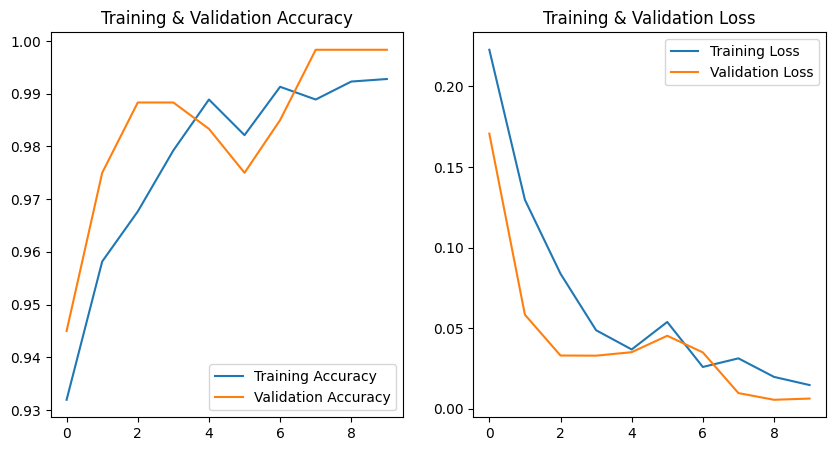

In [ ]:
epochs = 10
history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')

plt.show()

In [ ]:
import cv2
image_path = str(cats[0])
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image, (img_height, img_width))
image_array = np.expand_dims(image_resized, axis=0)
image_array = tf.keras.applications.resnet50.preprocess_input(image_array)
print("Image shape for prediction:", image_array.shape)


Image shape for prediction: (1, 180, 180, 3)


In [ ]:
# Run prediction on the processed image
pred = resnet_model.predict(image_array)

print("Raw prediction scores:", pred)

# Get the predicted class index
predicted_index = np.argmax(pred)

# Map index to class name
output_class = class_names[predicted_index]

print("The predicted class is:", output_class)



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Raw prediction scores: [[9.9993193e-01 6.8031070e-05 5.5360834e-11]]
The predicted class is: cats


In [ ]:
# Evaluate model on test dataset
test_loss, test_acc = resnet_model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 1.0000 - loss: 0.0038
Test Accuracy: 100.00%
Test Loss: 0.0048


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


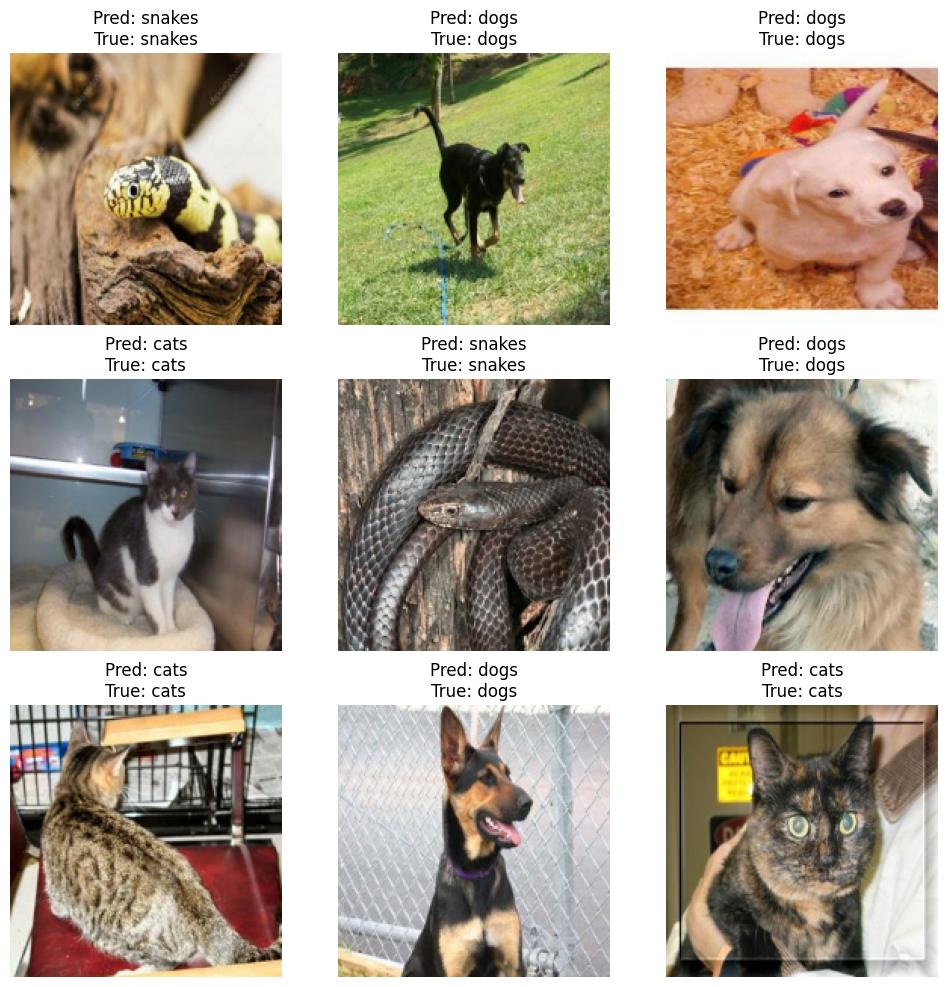

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 12))
for images, labels in test_ds.take(1):
    preds = resnet_model.predict(images)
    pred_classes = np.argmax(preds, axis=1)
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {class_names[pred_classes[i]]}\nTrue: {class_names[labels[i]]}")
        plt.axis("off")


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = resnet_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Classification Report:
               precision    recall  f1-score   support

        cats       1.00      0.99      1.00       151
        dogs       0.99      1.00      1.00       162
      snakes       1.00      1.00      1.00       167

    accuracy                           1.00       480
   macro avg       1.00      1.00      1.00       480
weighted avg       1.00      1.00      1.00       480

Confusion Matrix:
 [[150   1   0]
 [  0 162   0]
 [  0 

In [ ]:
!pip install tf2onnx onnx onnx2pytorch




INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 606.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.

In [ ]:
# Save your trained Keras model
resnet_model.save("best_model.keras")

print("✅ Model saved as best_model.keras")


✅ Model saved as best_model.keras


In [ ]:
# Save your trained Keras model as .h5
resnet_model.save("best_model.h5")

print("✅ Model saved as best_model.h5")



✅ Model saved as best_model.h5


In [ ]:
import numpy as np
if not hasattr(np, "cast"):
    np.cast = lambda dtype: (lambda arr: np.asarray(arr, dtype=dtype))


In [ ]:
import tensorflow as tf
import tf2onnx
import torch
import torch.nn as nn
import torchvision.models as models
import onnx
from onnx2pytorch import ConvertModel

# ---------------- Step 1: Save & Load Keras Model ----------------
resnet_model.save("best_model.keras")
keras_model = tf.keras.models.load_model("best_model.keras")
print("✅ Keras model saved and loaded")

# ---------------- Step 2: Define tf.function (NOT ConcreteFunction) ----------------
spec = (tf.TensorSpec((1,180,180,3), tf.float32, name="input"),)
tf_func = tf.function(lambda x: keras_model(x))

# ---------------- Step 3: Convert tf.function → ONNX ----------------
onnx_model_proto, _ = tf2onnx.convert.from_function(
    tf_func,
    input_signature=spec,
    opset=13
)
onnx.save_model(onnx_model_proto, "temp_model.onnx")
print("✅ Converted to ONNX at temp_model.onnx")

# ---------------- Step 4: Convert ONNX → PyTorch ----------------
torch_model = ConvertModel(onnx_model_proto)
print("✅ Converted ONNX to PyTorch")

# ---------------- Step 5: Define ResNet50 Architecture ----------------
num_classes = 3
resnet_model_pytorch = models.resnet50(pretrained=False)
resnet_model_pytorch.fc = nn.Linear(resnet_model_pytorch.fc.in_features, num_classes)

# ---------------- Step 6: Transfer ONNX Weights ----------------
resnet_model_pytorch.load_state_dict(torch_model.state_dict(), strict=False)
print("✅ Weights transferred to ResNet50")

# ---------------- Step 7: Save Training Checkpoint ----------------
optimizer = torch.optim.Adam(resnet_model_pytorch.parameters(), lr=0.001)
checkpoint = {
    "epoch": 0,
    "model_state_dict": resnet_model_pytorch.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "loss": None
}
torch.save(checkpoint, "checkpoint.pth")
print("✅ Training checkpoint saved as checkpoint.pth")



✅ Keras model saved and loaded


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# ---------------- Step 1: Define ResNet50 Architecture ----------------
num_classes = 3  # update if different
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# ---------------- Step 2: Load Checkpoint ----------------
checkpoint = torch.load("/content/checkpoint.pth", map_location="cpu")
model.load_state_dict(checkpoint["model_state_dict"])
print(f"✅ Checkpoint loaded (Epoch: {checkpoint['epoch']})")

# ---------------- Step 3: Set Model to Eval Mode ----------------
model.eval()

# ---------------- Step 4: Dummy Input Test ----------------
dummy_input = torch.randn(1, 3, 180, 180)  # (batch, channels, height, width)
with torch.no_grad():
    output = model(dummy_input)

print("✅ Output shape:", output.shape)
print("✅ Model checkpoint is working fine")



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Checkpoint loaded (Epoch: 0)
✅ Output shape: torch.Size([1, 3])
✅ Model checkpoint is working fine


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# ---------------- Step 1: Define ResNet50 Architecture ----------------
num_classes = 3  # change if your dataset has different classes
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# ---------------- Step 2: Load Checkpoint ----------------
checkpoint = torch.load("/content/checkpoint.pth", map_location="cpu")
model.load_state_dict(checkpoint["model_state_dict"])
print(f"✅ Checkpoint loaded (Epoch: {checkpoint['epoch']})")

# ---------------- Step 3: Set Model to Eval Mode ----------------
model.eval()

# ---------------- Step 4: Preprocessing ----------------
transform = transforms.Compose([
    transforms.Resize((180, 180)),         # resize to match training size
    transforms.ToTensor(),                 # convert to tensor
    transforms.Normalize(                  # normalize like ResNet expects
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# ---------------- Step 5: Load Real Image ----------------
image_path = "/content/animal_photos/Animals/cats/0_0887.jpg"  # change path
img = Image.open(image_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0)  # shape (1, 3, 180, 180)

# ---------------- Step 6: Run Prediction ----------------
with torch.no_grad():
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)

class_names = ["cats", "dogs", "snakes"]  # change according to your dataset
print("✅ Predicted class:", class_names[predicted.item()])


✅ Checkpoint loaded (Epoch: 0)
✅ Predicted class: snakes


In [ ]:
import torch.nn.functional as F

# Run prediction again but include softmax
with torch.no_grad():
    output = model(img_tensor)
    probabilities = F.softmax(output, dim=1)[0]  # shape: (num_classes,)
    predicted = torch.argmax(probabilities).item()

class_names = ["cats", "dogs", "snakes"]

print("✅ Predicted class:", class_names[predicted])
print("🔍 Probabilities:")
for idx, prob in enumerate(probabilities):
    print(f"{class_names[idx]}: {prob:.4f}")






✅ Predicted class: snakes
🔍 Probabilities:
cats: 0.0000
dogs: 0.0000
snakes: 1.0000


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# ✅ Define transforms to match your training preprocessing
transform = transforms.Compose([
    transforms.Resize((180,180)),
    transforms.ToTensor()
])

# ✅ Load your test dataset (replace path with your test folder)
test_dataset = datasets.ImageFolder("/content/animal_photos/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ✅ Load checkpointed model
num_classes = len(test_dataset.classes)
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
checkpoint = torch.load("checkpoint.pth", map_location="cpu")
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print(f"✅ Checkpoint loaded (Epoch: {checkpoint['epoch']})")

# ✅ Evaluate on test data
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# ✅ Accuracy
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"✅ Test Accuracy: {accuracy*100:.2f}%")

# ✅ Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_dataset.classes,
            yticklabels=test_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ✅ Classification Report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))




FileNotFoundError: Couldn't find any class folder in /content/animal_photos/test.